# DATA INCUBATOR

# SHUTLLE SCHEDULING APP: NYC TAXI TRIP DATA

In this project, I used NYC taxi trips public dataset to investigate possible improvements to transportation. The idea is to identify similar rides (in terms of starting and ending locations, as well as pick-up times), and grouping them together to schedule a shuttle service. I used K-Means clustering algorithm to group the trips together, and analyzed what percentage of the rides can be potentially reduced by this approach.

http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

<img src="taxi-clipart.jpg" alt="Drawing" style="width: 200px;"/>

In [254]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from matplotlib.ticker import FuncFormatter
matplotlib.style.use('fivethirtyeight')

import datetime
import time

from sklearn.cluster import MiniBatchKMeans, KMeans

## Define functions to process data

In [301]:
def convert_latitude_to_mile(latitude):
    mile_per_lattitude = 69.0 
    return latitude * mile_per_lattitude

def convert_longitude_to_mile(latitude, longitude):
    mile_per_lattitude = 69.0
    latitude_in_rad = np.pi * latitude / 180
    mile_per_longitude = np.cos (latitude_in_rad) * mile_per_lattitude
    
    return longitude * mile_per_longitude

def find_bounds(location_mile, c = 2.5, perc = 2.5):
    median = np.percentile(location_mile, 50)
    low    = np.percentile(location_mile, perc)
    high   = np.percentile(location_mile, 100 - perc)
    
    low_limit  = median - c * (median - low)
    high_limit = median + c * (high - median)
    
    return low_limit, median, high_limit

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x*1e-3)

formatter = FuncFormatter(thousands)

## Read Data

In [256]:
df = pd.read_csv('yellow_tripdata_2016-01.csv', index_col=0) 
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
df["day"] = df["tpep_pickup_datetime"].apply(lambda dt: datetime.datetime(year=dt.year, month=dt.month, day=dt.day))
df["count"] = 1

df = df.drop(['RatecodeID','store_and_fwd_flag','payment_type',
              'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge'], axis=1)

print ("reading data is DONE")

reading data is DONE


## Pre-processing

In [257]:
# degree - > mile conversion
df['pickup_latitude_mile'] = df[["pickup_latitude"]].apply(convert_latitude_to_mile)
df['pickup_longitude_mile'] = df[['pickup_latitude', 'pickup_longitude']].apply(lambda x: convert_longitude_to_mile(*x), axis=1)

print ("pick-up location is converted")

df['dropoff_latitude_mile'] = df[["dropoff_latitude"]].apply(convert_latitude_to_mile)
df['dropoff_longitude_mile'] = df[['dropoff_latitude', 'dropoff_longitude']].apply(lambda x: convert_longitude_to_mile(*x), axis=1)

print ("drop-off location is converted")

pick-up location is converted
drop-off location is converted


## Clean Data

In [258]:
lat_mile  = np.array(df['pickup_latitude_mile'].tolist()  + df['dropoff_latitude_mile'].tolist())
long_mile = np.array(df['pickup_longitude_mile'].tolist() + df['dropoff_longitude_mile'].tolist())

lat_low_limit , lat_median , lat_high_limit  = find_bounds(lat_mile)
long_low_limit, long_median, long_high_limit = find_bounds(long_mile)

# exclude outliers

df = df[(df['pickup_latitude_mile']   > lat_low_limit)  & (df['pickup_latitude_mile'] < lat_high_limit)]
df = df[(df['pickup_longitude_mile']  > long_low_limit) & (df['pickup_longitude_mile'] < long_high_limit)]
df = df[(df['dropoff_latitude_mile']  > lat_low_limit)  & (df['dropoff_latitude_mile'] < lat_high_limit)]
df = df[(df['dropoff_longitude_mile'] > long_low_limit) & (df['dropoff_longitude_mile'] < long_high_limit)]

print ("outliers are EXCLUDED")

# normalize locations

df['pickup_latitude_mile']  = df['pickup_latitude_mile']  - lat_median 
df['pickup_longitude_mile'] = df['pickup_longitude_mile'] - long_median
df['dropoff_latitude_mile'] = df['dropoff_latitude_mile'] - lat_median 
df['dropoff_longitude_mile']= df['dropoff_longitude_mile']- long_median

print ("normalization is DONE")

outliers are EXCLUDED
normalization is DONE


## Daily average of total number of trips and passengers

In [285]:
df_avg = df.groupby("day").agg({ "count": "count", 
                        "passenger_count" : 'sum',
                        "trip_distance" : 'sum' })

print ("Averege number of trips each day : ", df_avg["count"].mean() // 1)
print ("Averege number of passengers each day : ", df_avg["passenger_count"].mean() // 1)
print ("Averege miles driven each day : ", df_avg["trip_distance"].mean() // 1)

Averege number of trips each day :  344390.0
Averege number of passengers each day :  576669.0
Averege miles driven each day :  1597133.0


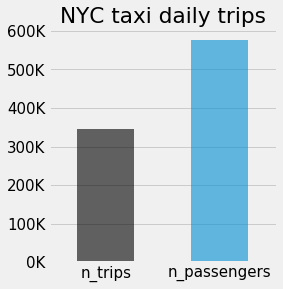

In [307]:
matplotlib.rcParams['font.size'] = 15
fig = plt.figure(0, figsize = (8,4))
ax = plt.subplot(1, 2, 1)

plt.bar([1], [df_day["count"].mean()], width=0.5, alpha = 0.6, color = 'k' )
plt.bar([2], [df_day["passenger_count"].mean()], width=0.5, alpha = 0.6)

ax.yaxis.set_major_formatter(formatter)
plt.xticks([1,2], ('n_trips',"n_passengers"))
plt.title("NYC taxi daily trips")
plt.xlim([0.5,2.5])
plt.gca().xaxis.grid(False)

plt.show()

* Lots of trips and passengers per day! ** Can we improve this? **

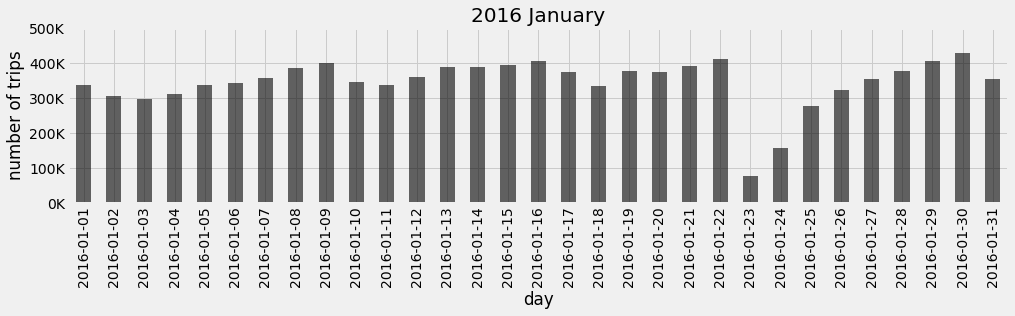

In [308]:
matplotlib.style.use('fivethirtyeight')

ax = df_day["count"].plot(kind='bar', ylim = [0, 500000], figsize = (15,3),  alpha = 0.6, color = 'k')
ax.yaxis.set_major_formatter(formatter)

plt.ylabel('number of trips')
plt.title('2016 January')
plt.show()

* We see increased trend in the number of trips as approaching to weekends.
* The substantial decrease in the number of trips between Jan 23, 2016 reflects a large storm!

https://www.nbcnewyork.com/news/local/NYC-New-York-City-Blizzard-Biggest-Ever-January-23-2016-377435221.html

## Partition data by pick up times

To maximize the efficiency in scheduling the shuttles, I partition the dataset into 30 min pick-up time intervals

In [314]:
# group by time intervals
TIME_BIN = 30 * 60 # 30 mins
df['pickup_time_epoch_sec']  = df['tpep_pickup_datetime'].astype(np.int64) // 10**9
df["pickup_time_bin"] = df['pickup_time_epoch_sec'] // TIME_BIN
df["pickup_time_bin"] = df["pickup_time_bin"]  - df["pickup_time_bin"].min()

df_list = []
for group, frame in df.groupby("pickup_time_bin"):
    df_list.append(frame)  

##  Number of trips versus time slots

Let's first see how many rides occur in each of the 30 minute intervals.

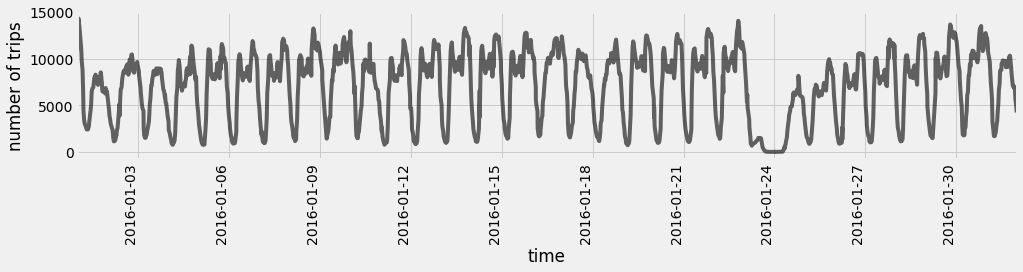

In [315]:
matplotlib.style.use('fivethirtyeight')
fig = plt.figure(0, figsize = (15,3))

df_plot = pd.DataFrame()
df_plot["num_trips"] = [dfx.shape[0] for dfx in df_list ]

df_plot["times"] = [dfx['tpep_dropoff_datetime'].iloc[0] for dfx in df_list ]
df_plot["times"] = pd.to_datetime(df_plot["times"])
df_plot = df_plot.set_index('times')

df_plot["num_trips"].plot(alpha = 0.6, color = 'k')
plt.xlabel('time'), plt.ylabel('number of trips')
plt.xticks(rotation='vertical')
plt.show()


* The date and night times are nicely reflected by the fluctuations in the 1-month period.

## Cluster similar routes ( pickup -> dropoff ) in each time slot

At each time slot, I would like to schedule shuttles at various locations. The shuttles will be scheduled with at least 10 passengers taking approximately the same route and with the condition that no passenger walks more than 0.3 miles (approx. 10 minutes) in total. Let's define these constraining parameters below.

In [317]:
MAX_WALKING_DISTANCE = 0.3
MIN_PASSANGER_COUNT = 10

### Single time slot clustering analysis

Before doing the full analysis, I first would like visualize several examples of pick-up and drop-off clusters in a single time slot.

In [318]:
df_k = df_list[80]
dt = df_k.iloc[1]['tpep_pickup_datetime']
dt = dt.strftime('%Y-%m-%d') + " at " + str (dt.hour) + ":" + str (dt.minute) + str ("0")

Here is clustering with scikit-learn library

In [60]:
# Compute clustering with k-Means
X = np.array(df_k.loc[:, ['pickup_longitude_mile','pickup_latitude_mile', 'dropoff_longitude_mile','dropoff_latitude_mile']])

# Try to assign approx. MIN_PASSANGER_COUNT passengers per cluster
n_clusters = X.shape[0] // MIN_PASSANGER_COUNT

k_means = KMeans(init='k-means++', n_clusters= n_clusters, n_init=10)
k_means.fit(X)

k_means_cluster_centers = k_means.cluster_centers_
k_means_labels = k_means.predict(X)

Write cluster information back to the dataset

In [61]:
distances_to_center = []
for i in range (0, X.shape[0]):
    cluster_id = k_means_labels[i]
    cluster_center = k_means_cluster_centers[cluster_id]
    dist_to_center = np.linalg.norm( X[i,:2] - cluster_center[:2]) + np.linalg.norm( X[i,2:] - cluster_center[2:])
    distances_to_center.append (dist_to_center)

df_k["cluster_id"] = k_means_labels
df_k["dist_to_center"] = distances_to_center

Assign bus at each cluster center when there are at least MIN_PASSANGER_COUNT = 10 passsengers nearby

In [62]:
df_k["walkable_to_center"] = df_k["dist_to_center"] <= MAX_WALKING_DISTANCE

df_k_walk = df_k[df_k["walkable_to_center"]]
df_k_walk = df_k_walk.groupby("cluster_id").agg('sum')["passenger_count"].reset_index()
df_k_bus  = df_k_walk[df_k_walk["passenger_count"] >= MIN_PASSANGER_COUNT]

bus_id= set(df_k_bus["cluster_id"])
df_k["bus_scheduled"] = df_k["cluster_id"].apply(lambda x: x in bus_id)
df_k["bus_location"]  = df_k ["cluster_id"].apply(lambda x: k_means_cluster_centers[x])

df_k["assigned_to_bus"] = df_k["bus_scheduled"] & df_k["walkable_to_center"] 

Here comes the passengers assigned to shuttles.

In [152]:
df_bus = df_k[df_k["assigned_to_bus"]] 
df_k["passenger_count"].sum(), df_bus["passenger_count"].sum(), dt

(16332, 2223, '2016-01-02 at 16:00')

* On 2016-01-02 at 16:00, more than 10% of the passengers can be assigned to shuttles !

Let's visualize some of the clusters.

Mostly for fun, I cropped NYC map to visualize the clusters in a more realistic context. The latitude/longitude corners are given by [-74.10, -73.53],  [40.58, 40.87]. I introduced a helper method below to convert between image coordinates and latitude/longitude.

In [64]:
def find_indices(latitude, longitude): 
    x, y = [-74.10, -73.53],  [40.58, 40.87]
    x_pixels, y_pixels = 800, 500
    
    dx = (x[1]- x[0]) / x_pixels
    dy = (y[1]- y[0]) / y_pixels

    x_idx = int((latitude - x[0]) / dx)
    y_idx = int((longitude - y[0]) / dy)

    return max(min(x_idx, x_pixels-1), 0), max(min(y_idx, y_pixels-1), 0)

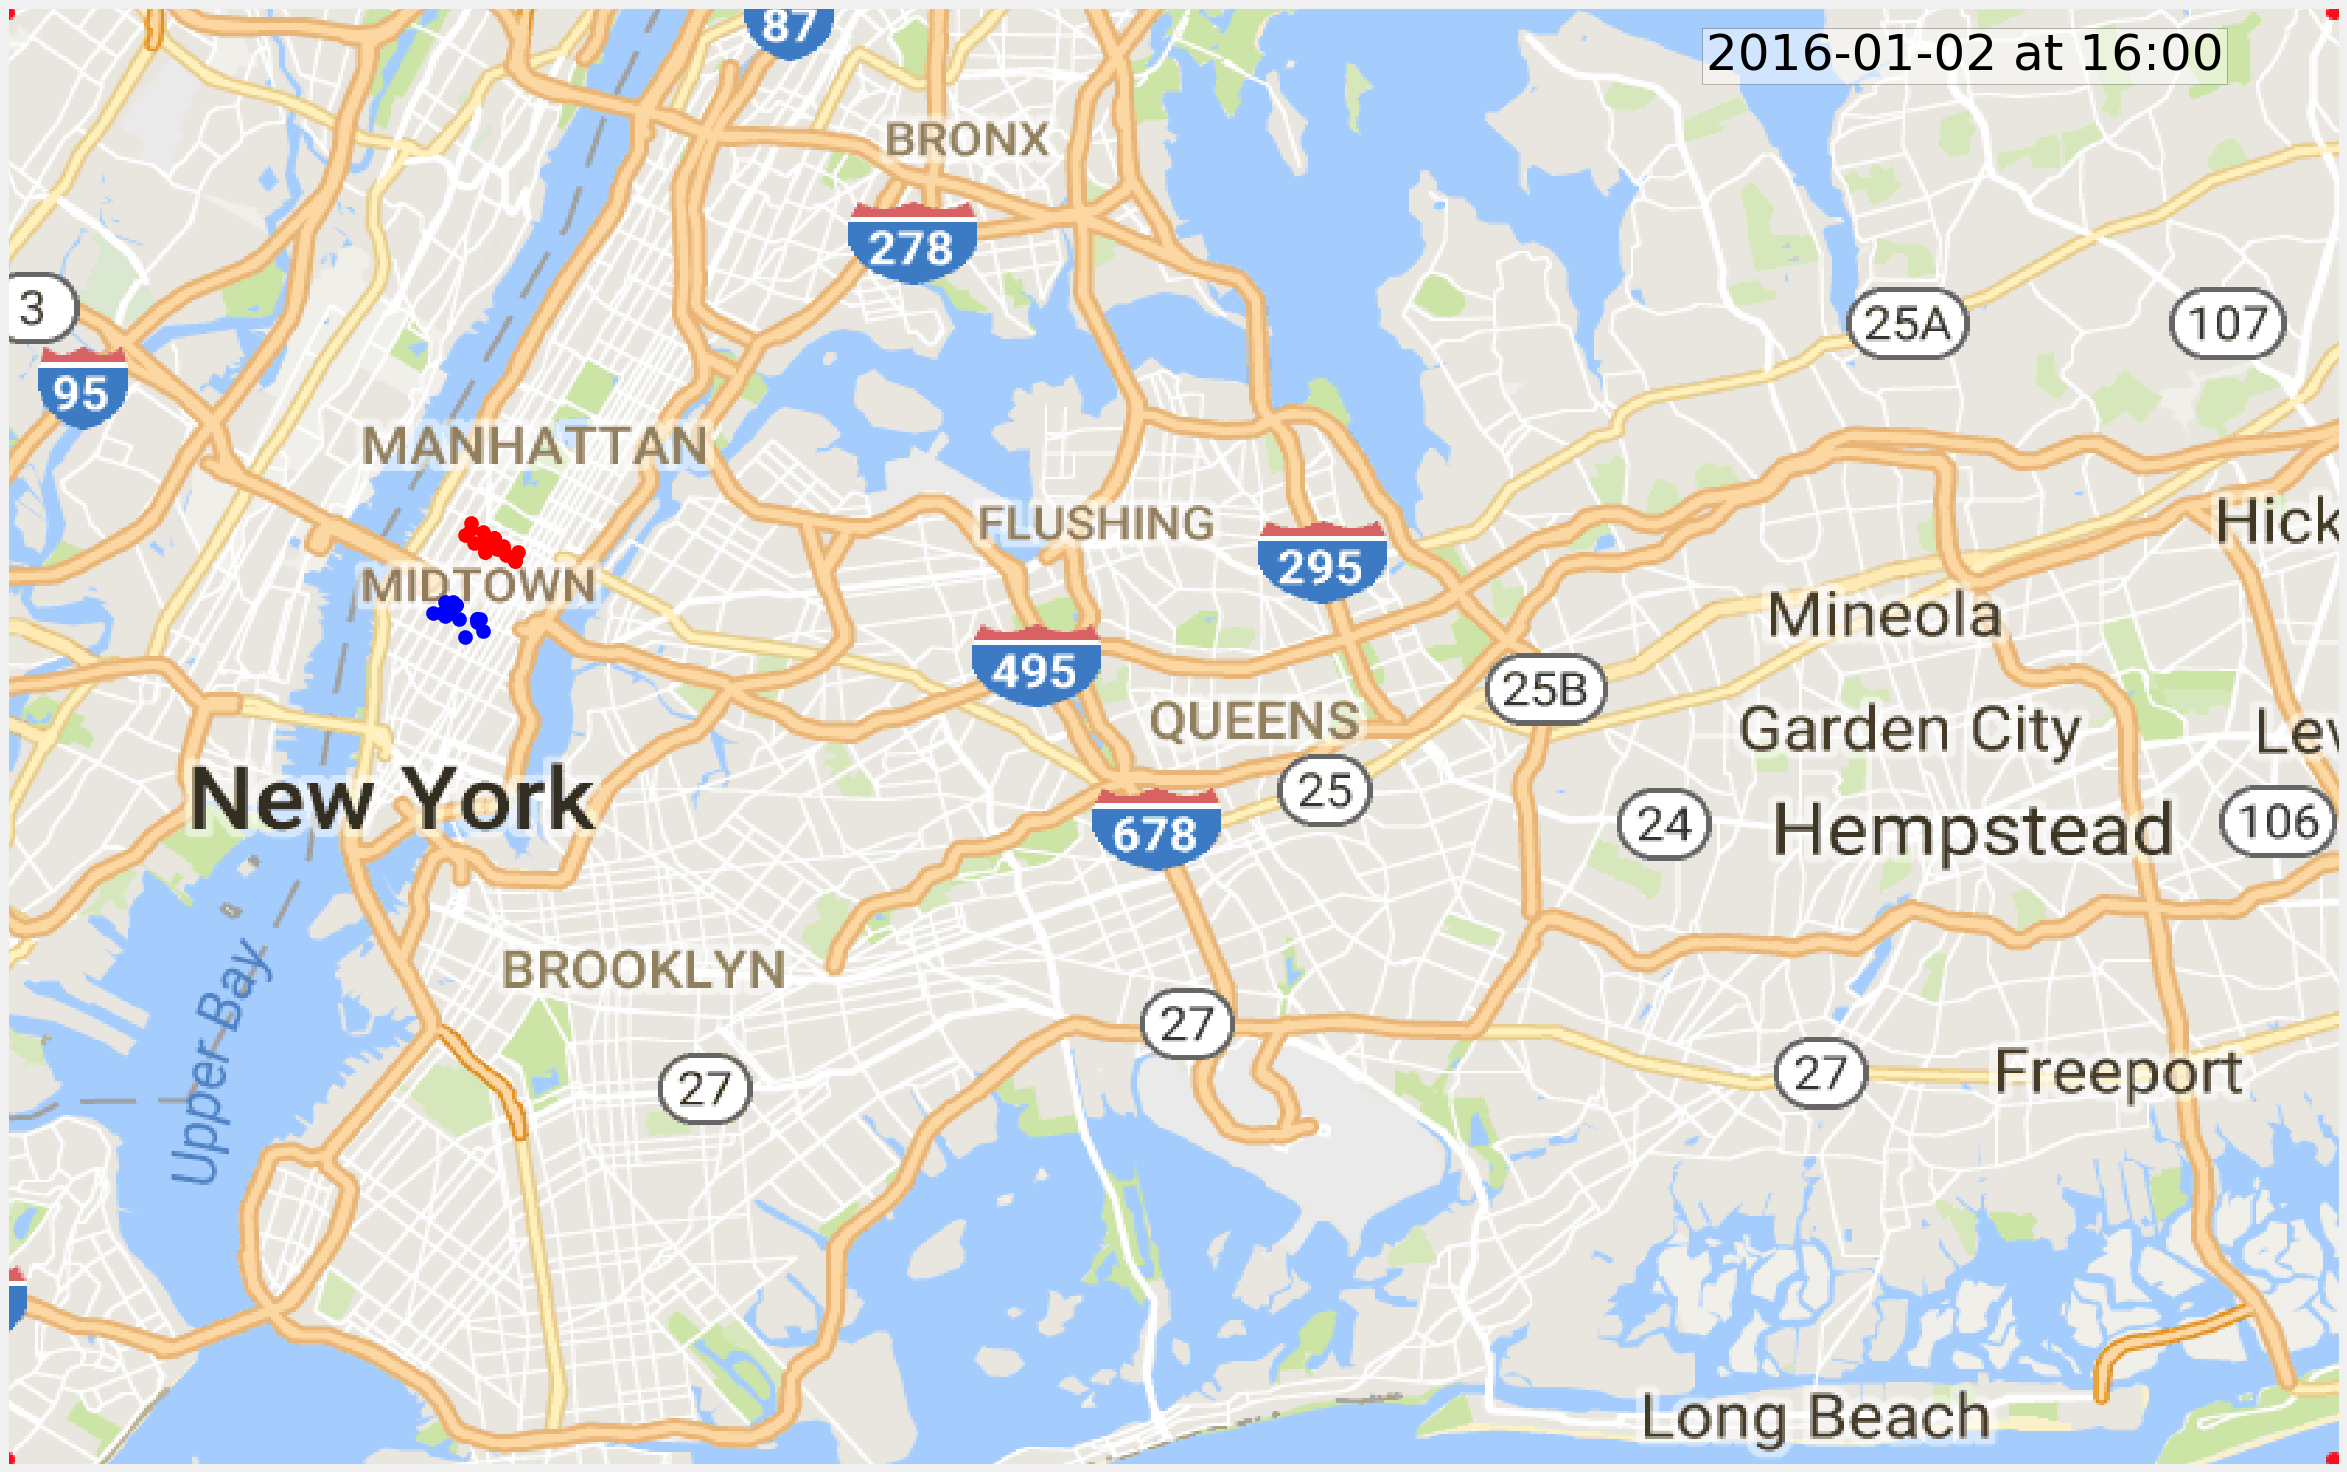

In [153]:
n = 9 # some sample cluster

locations = df_k[df_k["cluster_id"] == df_bus["cluster_id"].tolist()[n]]
X = np.array(locations.loc[:, ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])

pickups = []
dropoffs = []
for row in X:
    pickups.append((row[0], row[1]))
    dropoffs.append((row[2], row[3]))
locations = pickups + dropoffs

img = plt.imread("NYC.png") 
fig = plt.figure(figsize=(40, 25))

ax = fig.add_subplot(1,1,1) 
ax.imshow(img, extent=[0, 800, 0, 500]) 

for i in range(0, len(pickups)):
    p = find_indices(pickups[i][1], pickups[i][0] )
    d = find_indices(dropoffs[i][1], dropoffs[i][0])

    ax.scatter([p[0]], [p[1]], s=200, color='red' )
    ax.scatter([d[0]], [d[1]], s=200, color='blue')
    
dt_text = ax.text(0.95, 0.95, dt,
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='k', fontsize=50)
dt_text.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='k'))
    
plt.xticks([])
plt.yticks([])
plt.show()

* Lots of people are going into the same direction at the same 30 minute interval !!

Here are some more examples where bus stops and the directions are given:

In [104]:
df_plot = df_bus.groupby("cluster_id").agg({"passenger_count": "sum", 
                                            "pickup_longitude" : 'mean',
                                            "pickup_latitude" : 'mean',
                                            "dropoff_longitude" : 'mean',
                                            "dropoff_latitude" : 'mean' })

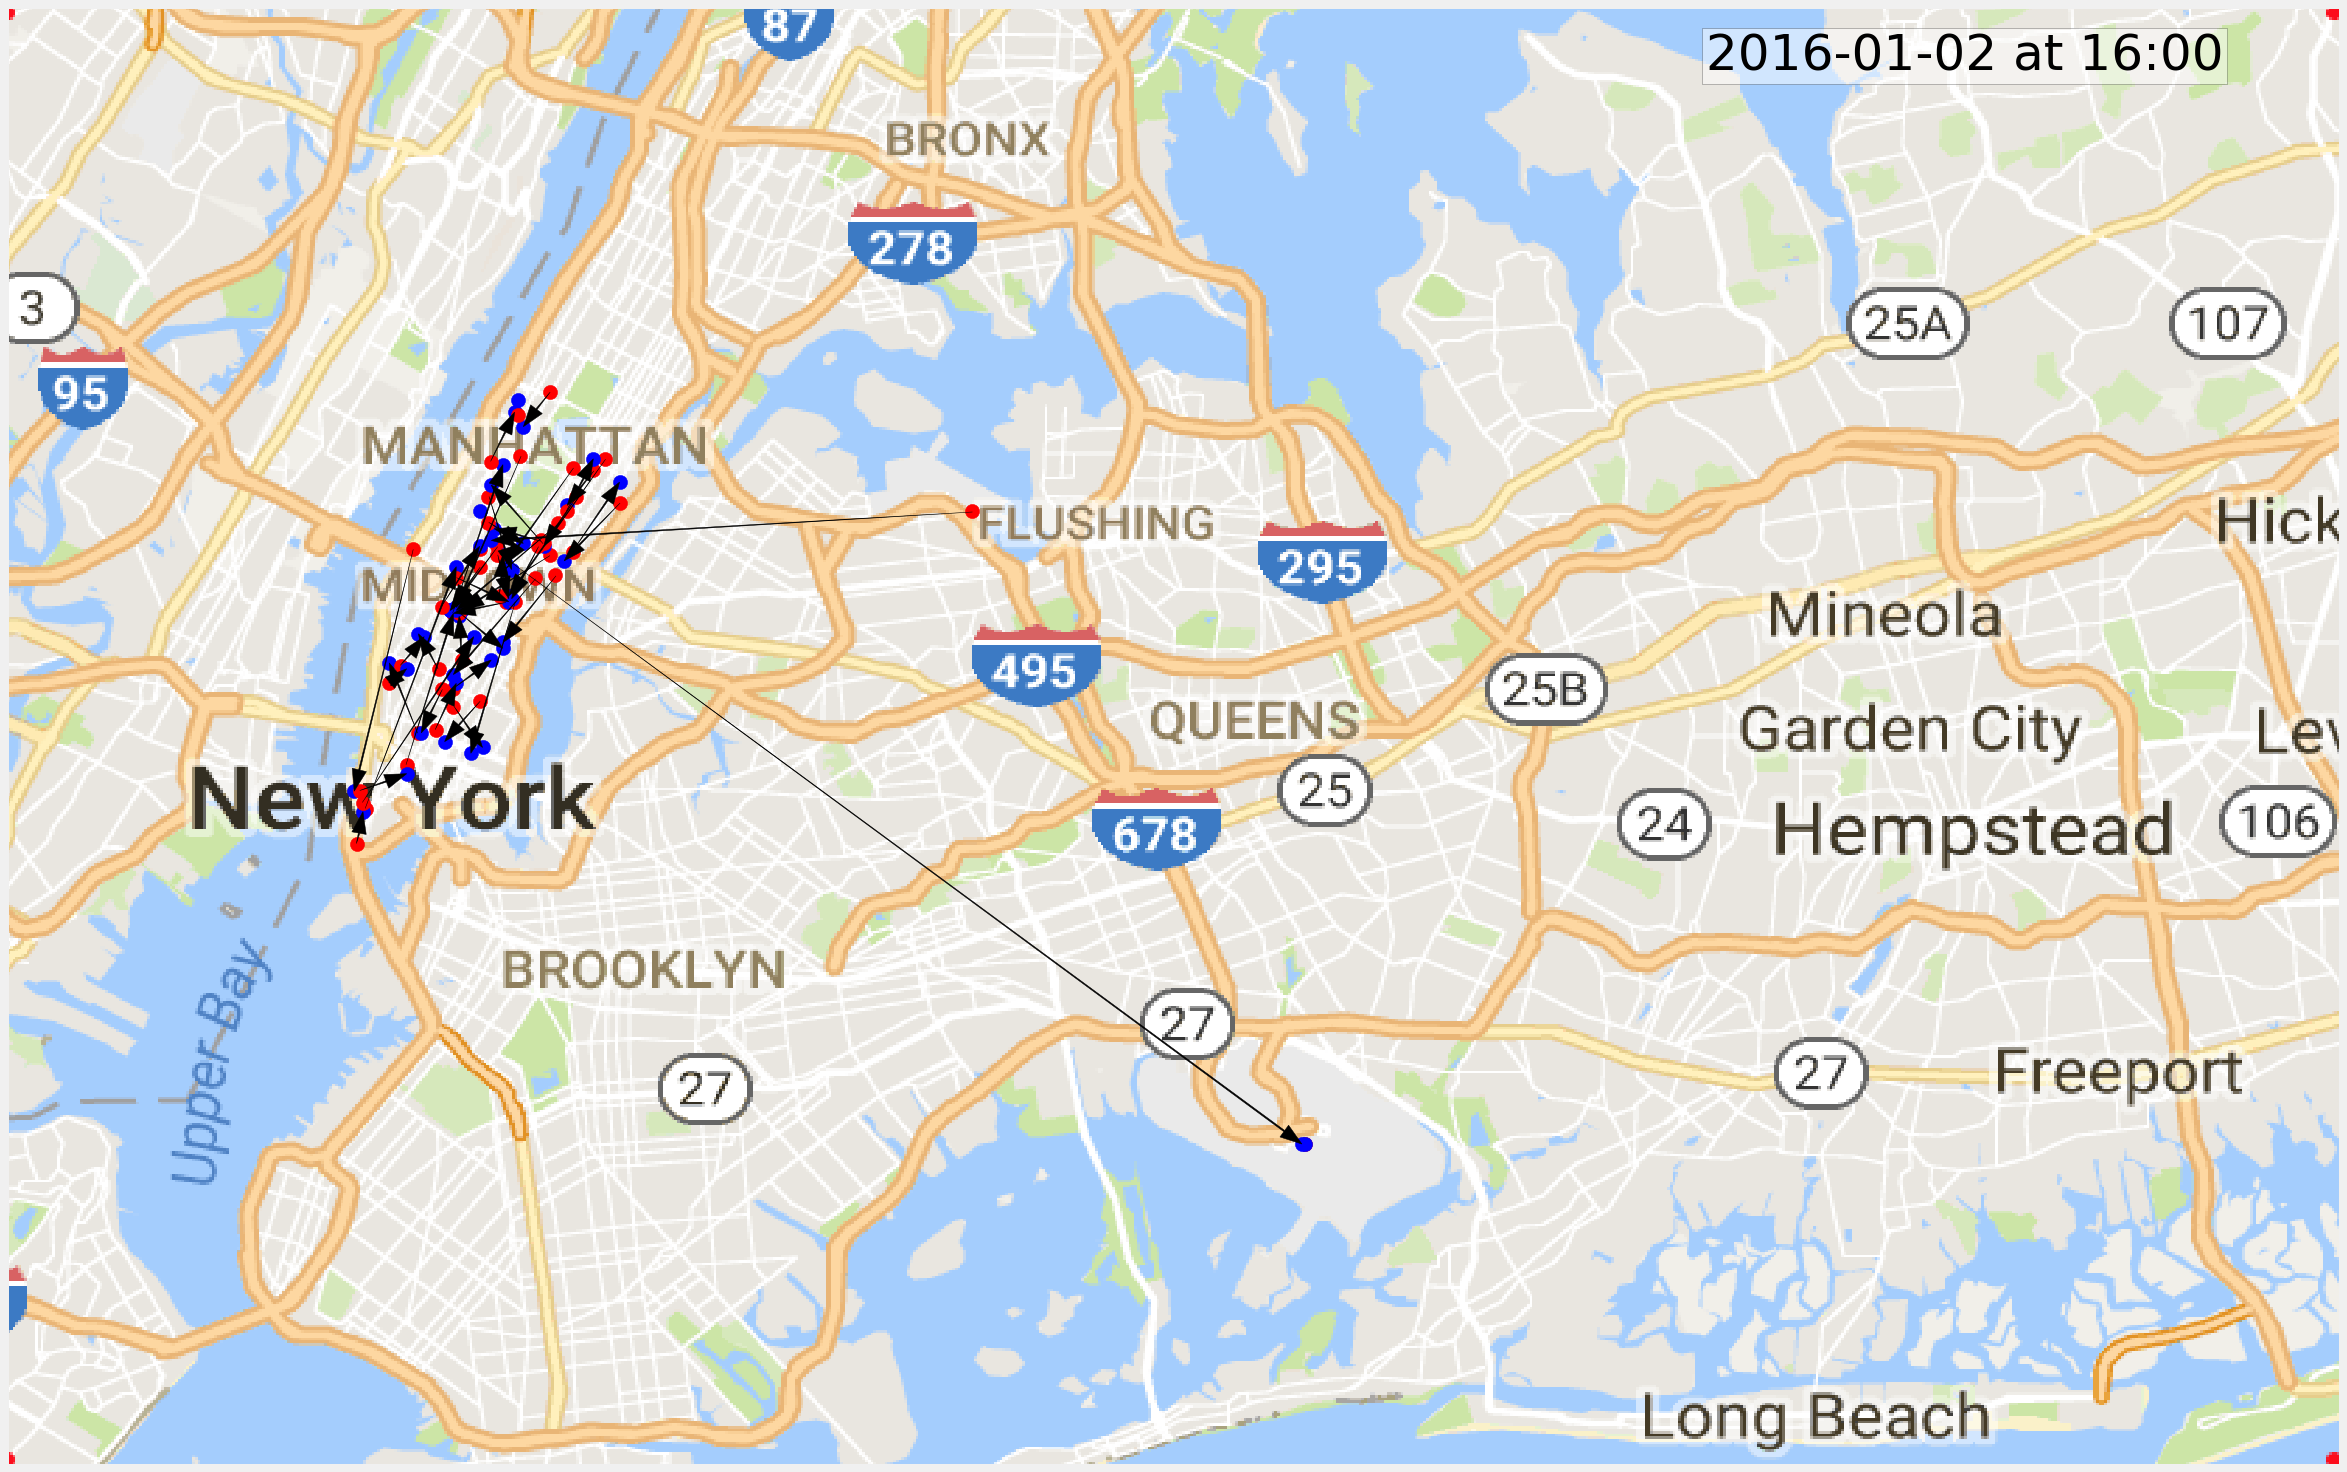

In [154]:
locations = df_plot.head(50)
X = np.array(locations.loc[:, ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])

pickups = []
dropoffs = []
for row in X:
    pickups.append((row[0], row[1]))
    dropoffs.append((row[2], row[3]))
locations = pickups + dropoffs

img = plt.imread("NYC.png") 
fig = plt.figure(figsize=(40, 25))
ax = fig.add_subplot(1,1, 1) 
ax.imshow(img, extent=[0, 800, 0, 500]) 

for i in range(0, len(pickups)):
# for i in range(30, 40):
    
    p = find_indices(pickups[i][1], pickups[i][0] )
    d = find_indices(dropoffs[i][1], dropoffs[i][0])

    ax.scatter([p[0]], [p[1]], s=200, color='red' )
    ax.scatter([d[0]], [d[1]], s=200, color='blue')
    
    if d[0] - p[0] != 0:
        ax.arrow(p[0], p[1], d[0]- p[0], d[1]- p[1], width=0.5, head_width=5, length_includes_head=True, color='k' )

dt_text = ax.text(0.95, 0.95, dt,
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='k', fontsize=50)
dt_text.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='k'))

plt.xticks([])
plt.yticks([])
plt.show()

* Vast majority of rides and clusters fall into Manhattan, and with some people going out or coming from two major airports.

### Full clustering analysis

Now, it comes to the analysis for a wider time range. I focus on the first 5 days of the dataset.

In [ ]:
df_list = df_list[: 240] # 240 half-hour intervals = 5 days

Let's first wrap the clustering algorithm into a function

In [76]:
def clustering(df_k):
     # Compute clustering with k-Means
    X = np.array(df_k.loc[:, ['pickup_longitude_mile','pickup_latitude_mile', 'dropoff_longitude_mile','dropoff_latitude_mile']])

    # Try to assign approx. MIN_PASSANGER_COUNT passengers per cluster
    n_clusters = X.shape[0] // MIN_PASSANGER_COUNT

    k_means = KMeans(init='k-means++', n_clusters= n_clusters, n_init=10)
    k_means.fit(X)

    k_means_cluster_centers = k_means.cluster_centers_
    k_means_labels = k_means.predict(X)

    # Compute each passenger's distance to cluster center

    distances_to_center = []
    for i in range (0, X.shape[0]):
        cluster_id = k_means_labels[i]
        cluster_center = k_means_cluster_centers[cluster_id]
        dist_to_center = np.linalg.norm( X[i,:2] - cluster_center[:2]) + np.linalg.norm( X[i,2:] - cluster_center[2:])
        distances_to_center.append (dist_to_center)


    df_k["cluster_id"] = k_means_labels
    df_k["dist_to_center"] = distances_to_center

    # Assign bus at cluster center when there are at least MIN_PASSANGER_COUNT passsengers nearby

    df_k["walkable_to_center"] = df_k["dist_to_center"] <= MAX_WALKING_DISTANCE

    df_k_walk = df_k[df_k["walkable_to_center"]]
    df_k_walk = df_k_walk.groupby("cluster_id").agg('sum')["passenger_count"].reset_index()
    df_k_bus = df_k_walk[df_k_walk["passenger_count"] >= MIN_PASSANGER_COUNT]

    bus_id= set(df_k_bus["cluster_id"])
    df_k["bus_scheduled"] = df_k["cluster_id"].apply(lambda x: x in bus_id)
    df_k["bus_location"]  = df_k ["cluster_id"].apply(lambda x: k_means_cluster_centers[x])

    df_k["assigned_to_bus"] = df_k["bus_scheduled"] & df_k["walkable_to_center"] 
    
    return df_k


In [ ]:
df_processed_list = []
back_up_to_local_dir = False
for idx, df_k in enumerate(df_list):
    df_k = clustering(df_k)
    df_processed_list.append(df_k)
    
    # Write intermediates to file in case notebook crashes
    if back_up_to_local_dir:
        df_k.to_csv("processed%d.csv" % idx)
        
df_proc = pd.concat(df_processed_list)
df_proc.to_csv("yellow_tripdata_2016-01_processed.csv")

Load processed data

In [231]:
df_proc = pd.read_csv("yellow_tripdata_2016-01_processed.csv")
df_proc["tpep_pickup_datetime"] = pd.to_datetime(df_proc["tpep_pickup_datetime"])
df_proc["day"] = df_proc["tpep_pickup_datetime"].apply(lambda dt: datetime.datetime(year=dt.year, month=dt.month, day=dt.day))
df_proc[df_proc["assigned_to_bus"]].groupby("cluster_id").agg({"passenger_count": "sum"}).sum()/10

In [234]:
df_proc_bus = df_proc[df_proc["bus_scheduled"]]
assigned_passenger_count = df_proc_bus.groupby("day").agg({"passenger_count": "sum"})["passenger_count"].tolist()
daily_passenger_counts = df_proc.groupby("day").agg({"passenger_count": "sum"})

daily_passenger_counts["assigned_passenger_count"] = assigned_passenger_count
daily_passenger_counts = daily_passenger_counts.reset_index()
daily_passenger_counts["day"] = daily_passenger_counts["day"].astype(str)
daily_passenger_counts = daily_passenger_counts.set_index("day") 

daily_passenger_counts

,passenger_count,assigned_passenger_count
day,,
2016-01-01,604939,134502
2016-01-02,543939,161340
2016-01-03,514849,123810
2016-01-04,509827,151612
2016-01-05,549385,178600


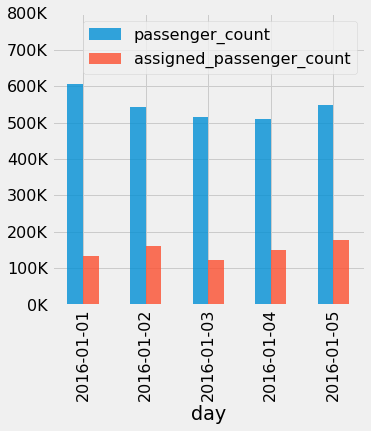

In [330]:
matplotlib.rcParams['font.size'] = 16
ax = daily_passenger_counts.plot(kind='bar', ylim = [0, 800000],  figsize=(5,5), alpha = 0.8)
ax.yaxis.set_major_formatter(formatter)
ax.yaxis.set_label("count")


* ** As we see above, the passengers can be consistently assigned to shuttles. **

* **Offering optimized shuttle rides can potentially result in 20% reduction in the traffic, and the resources, and more importantly achieving less environmental pollution! **

## Further notes


* Overall, there is a significant potential of offering dynamic shuttle scheduling service!


* Actual implementation of this idea would be a real-time predictive service that efficiently pools people together. 


* I used the simplest unsupervised clustering algorithm to demonstrate these conclusions. More sophisticated algorithms can be used to better cluster and obtain more efficient scheduling. 


* We can also investigate whether daily patterns can be generalized to future dates.